In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

import esmtools as et
from esmtools import stats

import shapefile
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gp
import regionmask
import matplotlib.patches as mpatches
import xesmf as xe

In [2]:
# Open dataset 
dir = '/home/jovyan/SOARS_2021/Data/NorESM2-LM/'
fn = 'tos_Omon_NorESM2-LM_omip2_r1i1p1f1_gn_198001-201812.nc'

data_tos = xr.open_dataset(dir+fn)
data_tos

<xarray.Dataset>
Dimensions:             (bnds: 2, i: 360, j: 385, time: 468, vertices: 4)
Coordinates:
  * time                (time) object 1980-01-16 12:00:00 ... 2018-12-16 12:0...
  * j                   (j) int32 1 2 3 4 5 6 7 ... 379 380 381 382 383 384 385
  * i                   (i) int32 1 2 3 4 5 6 7 ... 354 355 356 357 358 359 360
    latitude            (j, i) float64 ...
    longitude           (j, i) float64 ...
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds           (time, bnds) object ...
    vertices_latitude   (j, i, vertices) float64 ...
    vertices_longitude  (j, i, vertices) float64 ...
    tos                 (time, j, i) float32 ...
Attributes: (12/50)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               OMIP
    branch_method:             no parent
    branch_time:               0.0
    branch_time_in_child:      0.0
    branch_time_in_parent:     0.0
    ...                        ...
    variable_id:               tos
    variant_label:             r1i1p1f1
    license:                   CMIP6 model data produced by NCC is licensed u...
    cmor_version:              3.5.0
    tracking_id:               hdl:21.14100/b2de860b-745a-4fc6-8ca8-168cd3e21d25
    NCO:                       netCDF Operators version 4.9.9 (Homepage = htt...

In [3]:
# Change the time to be from DatetimeNoLeap to a Datetime64
data_tos['time'] = np.arange('1980-01-01','2019-01-01',dtype = 'datetime64[M]')
data_tos

<xarray.Dataset>
Dimensions:             (bnds: 2, i: 360, j: 385, time: 468, vertices: 4)
Coordinates:
  * time                (time) datetime64[ns] 1980-01-01 ... 2018-12-01
  * j                   (j) int32 1 2 3 4 5 6 7 ... 379 380 381 382 383 384 385
  * i                   (i) int32 1 2 3 4 5 6 7 ... 354 355 356 357 358 359 360
    latitude            (j, i) float64 ...
    longitude           (j, i) float64 ...
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds           (time, bnds) object 1980-01-01 00:00:00 ... 2019-01-0...
    vertices_latitude   (j, i, vertices) float64 ...
    vertices_longitude  (j, i, vertices) float64 ...
    tos                 (time, j, i) float32 ...
Attributes: (12/50)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               OMIP
    branch_method:             no parent
    branch_time:               0.0
    branch_time_in_child:      0.0
    branch_time_in_parent:     0.0
    ...                        ...
    variable_id:               tos
    variant_label:             r1i1p1f1
    license:                   CMIP6 model data produced by NCC is licensed u...
    cmor_version:              3.5.0
    tracking_id:               hdl:21.14100/b2de860b-745a-4fc6-8ca8-168cd3e21d25
    NCO:                       netCDF Operators version 4.9.9 (Homepage = htt...

In [4]:
tos = data_tos['tos']

In [5]:
# Create the target grid (1x1 degree)
ds_out = xe.util.grid_global(2, 2)
ds_out  # contains lat/lon values of cell centers and boundaries.

# Create regridder for `bilinear` interpolation
regridder = xe.Regridder(tos, ds_out, 'bilinear', ignore_degenerate=True)
#### To reuse weights, you need to provide a filename or weights

# Perform the regridding
dr_out = regridder(tos)

/home/jovyan/my-conda-envs/myenv/lib/python3.8/site-packages/xarray/core/dataarray.py:745: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/home/jovyan/my-conda-envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


In [6]:
dr_out

<xarray.DataArray 'tos' (time: 468, y: 90, x: 180)>
array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-1.73794801, -1.73895847, -1.73971041, ..., -1.73440188,
         -1.73561401, -1.73680313],
        [-1.74210681, -1.74246833, -1.74283276, ..., -1.74103192,
         -1.74136524, -1.74173818],
        [-1.75283372, -1.75293825, -1.75305332, ..., -1.75258605,
         -1.75265737, -1.75274001]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
...
        [-1.70775158, -1.70850263, -1.70963196, ..., -1.70734316,
         -1.70720814, -1.70732637],
        [-1.72848242, -1.72889893, -1.72932327, ..., -1.72724864,
         -1.72768306, -1.72807671],
        [-1.73181987, -1.73169246, -1.73156835, ..., -1.73221592,
         -1.73208223, -1.73195   ]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-1.71578841, -1.71606792, -1.71572471, ..., -1.71474686,
         -1.71495419, -1.71526366],
        [-1.7317083 , -1.73240212, -1.73299333, ..., -1.72965199,
         -1.73028629, -1.73100057],
        [-1.74149739, -1.74132019, -1.74114395, ..., -1.7420314 ,
         -1.74185335, -1.74167523]]])
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2018-12-01
    lon      (y, x) float64 -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0
    lat      (y, x) float64 -89.0 -89.0 -89.0 -89.0 ... 89.0 89.0 89.0 89.0
Dimensions without coordinates: y, x
Attributes:
    regrid_method:  bilinear

In [7]:
# select dimensions!
dr_out['time'] = pd.date_range("1980-01", "2018-12", freq="MS")
tos = dr_out
tos = tos.sel(y=slice(40,80) ,x=slice(5,45))

In [8]:
# remove long term trend for each grid cell
var = stats.rm_poly(tos,order=2,dim='time',nan_policy='drop')

In [9]:
# 1982-2010 period
base = var.sel(time=slice('1982-01','2010-12'))
tos_base = base

In [10]:
# Blob period
blob = var.sel(time=slice('2013-07','2016-06'))
tos_blob = blob

In [11]:
# Difference between the two periods
blob_anom = blob.groupby('time.month') - base.groupby('time.month').mean()

In [12]:
# Resample to two month resolution
cesm = blob_anom.resample(time='2M').mean()
cesm

<xarray.DataArray (y: 40, x: 40, time: 19)>
array([[[-0.0749962 , -0.04929163, -0.04542422, ...,  0.74738986,
          0.82733351,  0.54516987],
        [-0.12728093, -0.11489798, -0.0446169 , ...,  0.85186434,
          0.92321613,  0.69210696],
        [-0.15422966, -0.12229037, -0.06721095, ...,  0.92194622,
          0.97437864,  0.81790497],
        ...,
        [-0.52263507, -0.47760364, -0.55006294, ...,  0.77055026,
          0.96676272,  1.22425938],
        [-0.5252662 , -0.49508683, -0.56387473, ...,  0.6893718 ,
          0.99853259,  1.31561518],
        [-0.44383846, -0.43741113, -0.53975361, ...,  0.60727386,
          1.01152974,  1.42376143]],

       [[-0.10325396, -0.07104644,  0.08164173, ...,  0.97621627,
          1.20529577,  1.06825186],
        [-0.08500308, -0.0197945 ,  0.15529277, ...,  1.2265142 ,
          1.25174483,  1.15193593],
        [-0.05961379, -0.0655567 ,  0.02957097, ...,  1.44921835,
          1.35622036,  1.18258163],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[ 0.22972569, -1.29908976,  0.06777223, ..., -0.5643536 ,
         -0.53372238, -0.61047121],
        [-0.2727256 , -1.42531392,  0.27353173, ..., -0.57633364,
         -0.51310142, -0.07172704],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.26343644, -0.08325931,  0.1607127 , ..., -0.16409247,
         -0.16261359, -0.15841995],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]])
Coordinates:
  * time     (time) datetime64[ns] 2013-07-31 2013-09-30 ... 2016-07-31
    lon      (y, x) float64 -169.0 -167.0 -165.0 -163.0 ... -95.0 -93.0 -91.0
    lat      (y, x) float64 -9.0 -9.0 -9.0 -9.0 -9.0 ... 69.0 69.0 69.0 69.0
Dimensions without coordinates: y, x

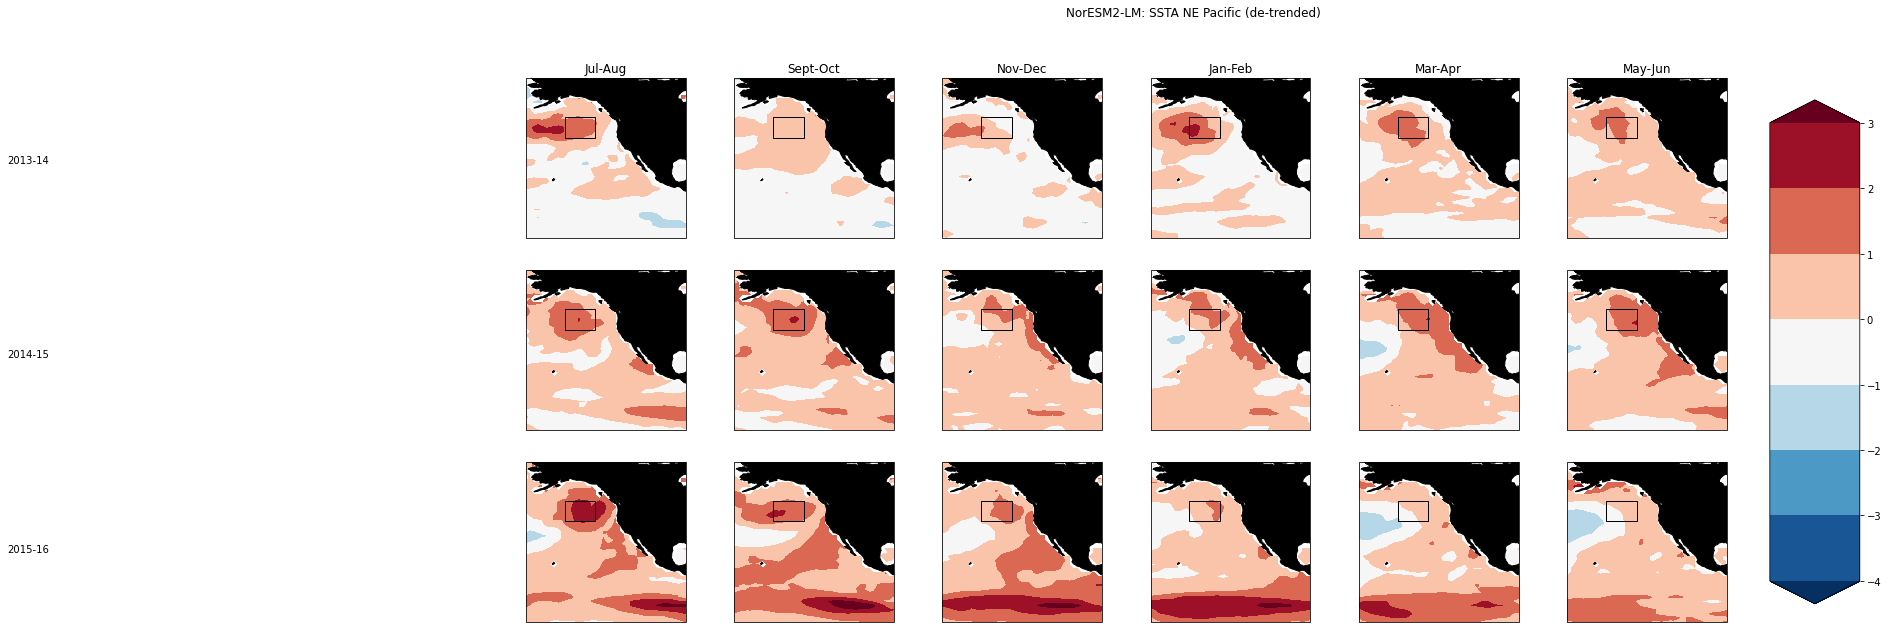

In [13]:
def panels(data,description,variable,depth,lower_bound,upper_bound, step,cmap):
    f, axs = plt.subplots(nrows=3,ncols=6,figsize=(25,10),
                          subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180))) 
    axs = axs.flatten()
    for i in range(0,18):
        im = axs[i].contourf(cesm.lon, cesm.lat, cesm.isel(time=i),
                         transform=ccrs.PlateCarree(), 
                         cmap=cmap,
                         levels=np.arange(lower_bound, upper_bound, step),
                         extend='both')
        axs[i].add_feature(cfeature.LAND, color='k')
        axs[i].add_patch(mpatches.Rectangle(xy=[210, 40], width=15, height=10,
                                    edgecolor='k',
                                    facecolor='none',
                                    transform=ccrs.PlateCarree())
                 )
    plt.suptitle("NorESM2-LM: " + description + " " + variable + " " + depth + " (de-trended)")
    axs[0].set_title("Jul-Aug"); axs[1].set_title("Sept-Oct")
    axs[2].set_title("Nov-Dec"); axs[3].set_title("Jan-Feb")
    axs[4].set_title("Mar-Apr"); axs[5].set_title("May-Jun")
    plt.text(-750,215,'2013-14')
    plt.text(-750,120,'2014-15')
    plt.text(-750,25,'2015-16')
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes([0.82, 0.15, 0.05, 0.7])
    f.colorbar(im, cax=cbar_ax,fraction=0.046,pad=0.04)
    
panels(tos,'SSTA','NE','Pacific',-4.0,4.0, 1.0,'RdBu_r')